In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd, seaborn as sns

import sys
sys.path.append('/ahg/regevdata/projects/CRISPR-libraries/prj2/evolution/abe8e/src/')
import _config, _lib

sys.path.append('/home/unix/maxwshen/')
from mylib import util

notebook_nm = 'fig_plot_full_trajectories'
results_dir = _config.RESULTS_PLACE + f'{notebook_nm}/'
util.ensure_dir_exists(results_dir)

Using data folder:
 /ahg/regevdata/projects/CRISPR-libraries/prj2/evolution/abe8e/data/


In [2]:
# Edit me and run all cells below
pnum = 2

if pnum in [2, 3]:
    datagroup = 'simple'
else:
    datagroup = 'simple_p1'

In [3]:
## Load data

true_df = pd.read_csv(f'/ahg/regevdata/projects/CRISPR-libraries/prj2/evolution/abe8e/out/data_multi/pv_groundtruth_0.0pct_t5_p{pnum}.csv')

true_df['Abbrev genotype'] = [_lib.full_to_abbrev(s) for s in true_df['Full genotype']]
true_df = true_df.drop(columns = 'Full genotype')

true_df.to_csv(results_dir + f'p{pnum}_ground_truth.csv')

## true

Plotting only gt trajectories: top 30. Trimming 4799 ...
Trimmed to 30 gts.
Saving to /ahg/regevdata/projects/CRISPR-libraries/prj2/evolution/abe8e/results/fig_plot_full_trajectories/p2_ground_truth.pdf ...


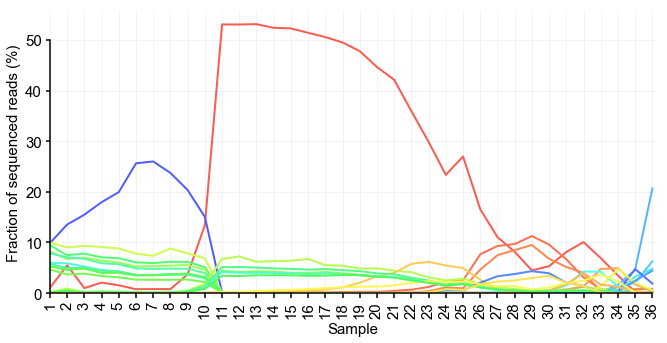

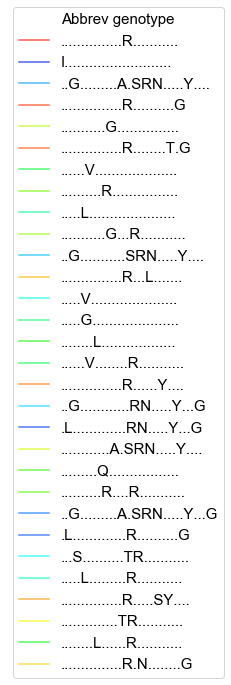

In [4]:
out_fn = results_dir + f'p{pnum}_ground_truth.pdf'
title = 'PACE {pnum} ground truth'

df = true_df

true_times = [s for s in true_df.columns if s != 'Abbrev genotype']
idx_to_time = {str(idx): t for idx, t in enumerate(true_times)}

filter_num = 30
print(f'Plotting only gt trajectories: top {filter_num}. Trimming {len(df)} ...')
df['max fq'] = df.apply('max', axis = 'columns')
df = df.sort_values(by = 'max fq', ascending = False)
df = df.iloc[:filter_num]
print(f'Trimmed to {len(df)} gts.')
df = df.drop(columns = ['max fq'])

melt_df = df.melt(
    id_vars = 'Abbrev genotype',
    var_name = 'Time',
    value_name = 'Frequency (%)',
)
melt_df['Frequency (%)'] *= 100

ts = sorted(list(set(melt_df['Time'])))
t_to_sample_num = {t: idx + 1 for idx, t in enumerate(ts)}
melt_df['Sample number'] = [t_to_sample_num[t] for t in melt_df['Time']]

gts = sorted(list(set(df['Abbrev genotype'])))
# colors = sns.color_palette('hls', int(len(gts) * 1.5))
colors = sns.hls_palette(n_colors = int(len(gts) * 1.5), s = 0.95, l = 0.65)
master_palette = {gt: color for gt, color in zip(gts, colors)}

#
import matplotlib
matplotlib.rc('font', family = 'Arial', size = 15)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
#

fig, ax = plt.subplots(figsize = (9.5, 5))

sns.lineplot(
    x = 'Sample number',
    y = 'Frequency (%)',
    hue = 'Abbrev genotype',
    palette = master_palette,
    ci = None,
    data = melt_df,
    linewidth = 2,
    ax = ax,
)
# plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
ax.get_legend().remove()
plt.xticks(rotation = 90)
plt.grid(alpha = 0.2)
plt.ylim(
    bottom = 0, 
    # top = 100 + 2,
)
plt.xlim(left = 1, right = len(ts) + 0.2)
plt.xticks(np.arange(1, len(ts) + 1, 1))
plt.xlabel('Sample')
plt.ylabel('Fraction of sequenced reads (%)')

# if title != '':
#     plt.title(title)

plt.tight_layout()

##

sns.despine(trim = True)
ax.tick_params(length = 4.5, color = 'black', width = 1.5)
for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(1.5)
    ax.spines[axis].set_color('black')

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

print(f'Saving to {out_fn} ...')
plt.savefig(out_fn, transparent = True, bbox_inches = 'tight')

plt.show()
plt.close()
##


'''
    Save legend figure separately
    https://stackoverflow.com/questions/4534480/get-legend-as-a-separate-picture-in-matplotlib
'''
fig_leg = plt.figure(figsize = (3, 3))
ax_leg = fig_leg.add_subplot(111)

# add the legend from the previous axes
ax_leg.legend(
    *ax.get_legend_handles_labels(), 
    loc = 'center',
    handler_map = {}
)

# hide the axes frame and the x/y labels
ax_leg.axis('off')

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fig_leg.savefig(results_dir + f'p{pnum}_ground_truth_legend.pdf', transparent = True, bbox_inches = 'tight')

plt.show()
plt.close()
##

## any

In [6]:
def plot_inferred_trajectories(modelexp = 'modelexp_illumina', dataset_nm = '', out_fn = '', title = ''):
    inp_dir_g = _config.OUT_PLACE + f'g_collate_exps/'

    # Pick from /data/modelexp_x.csv, dataset col
    modelexp_design = pd.read_csv(_config.DATA_DIR + f'{modelexp}.csv')
    row = modelexp_design[modelexp_design['dataset'] == dataset_nm].iloc[0]
    tdf_dict = _lib.load_true_df_from_row(row)
    true_df = tdf_dict['true_df']
    idx_to_col = tdf_dict['idx_to_col']
    true_df_name = tdf_dict['memoize_key']
    nm = row['Name']

    df_fn = f'{inp_dir_g}/{modelexp}/genotype_matrix_{nm}.csv'

    df = pd.read_csv(df_fn, index_col = 0)
    
    df['Abbrev genotype'] = df.index
#     df['Full genotype'] = [_lib.abbrev_to_full(s, true_df) for s in list(df['Abbrev genotype'])]
    df = df.rename(columns = idx_to_col)
    df = df.reset_index(drop = True)
#     df = df.drop(columns = ['Full genotype'])

    # Parse .pdf to .csv
    csv_out_fn = '.'.join(out_fn.split('.')[:-1]) + '.csv'
    df.to_csv(f'{csv_out_fn}')
    
    melt_df = df.melt(
        id_vars = 'Abbrev genotype',
        var_name = 'Time',
        value_name = 'Frequency (%)',
    )
    melt_df['Frequency (%)'] *= 100
    
    ts = sorted(list(set(melt_df['Time'])))
    t_to_sample_num = {t: idx + 1 for idx, t in enumerate(ts)}
    melt_df['Sample number'] = [t_to_sample_num[t] for t in melt_df['Time']]
    
    
    #
    import matplotlib
    matplotlib.rc('font', family = 'Arial', size = 15)
    matplotlib.rcParams['mathtext.fontset'] = 'custom'
    matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
    #
    
    fig, ax = plt.subplots(figsize = (9.5, 5))

    gts = sorted(list(set(df['Abbrev genotype'])))
    colors = sns.color_palette('hls', int(len(gts) * 1.5))
    palette = {gt: master_palette[gt] if gt in master_palette else '#b6b9bc' for gt in gts}
    #     for gt in gts:
    #         if gt not in master_palette:
    #             print(gt)
    
    sns.lineplot(
        x = 'Sample number',
        y = 'Frequency (%)',
        hue = 'Abbrev genotype',
        palette = palette,
        ci = None,
        data = melt_df,
#         linewidth = 1.5,
        linewidth = 2,
        ax = ax,
    )
    # plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
    ax.get_legend().remove()
    plt.xticks(rotation = 90)
    plt.grid(alpha = 0.2)
    plt.ylim(
        bottom = 0, 
        # top = 100 + 2,
    )
    plt.xlim(left = 1, right = len(ts) + 0.2)
    plt.xticks(np.arange(1, len(ts) + 1, 1))
    plt.xlabel('Sample')
    plt.ylabel('Predicted fraction of sequenced reads (%)')
    
    # if title != '':
    #     plt.title(title)
    
    plt.tight_layout()

    ##

    sns.despine(trim = True)
    ax.tick_params(length = 4.5, color = 'black', width = 1.5)
    for axis in ['bottom', 'left']:
        ax.spines[axis].set_linewidth(1.5)
        ax.spines[axis].set_color('black')

    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42

    print(f'Saving to {out_fn} ...')
    plt.savefig(out_fn, transparent = True, bbox_inches = 'tight')

    plt.show()
    plt.close()
    ##
    
    return


Loading true df ...
Saving to /ahg/regevdata/projects/CRISPR-libraries/prj2/evolution/abe8e/results/fig_plot_full_trajectories/p2_t5_rl1.pdf ...


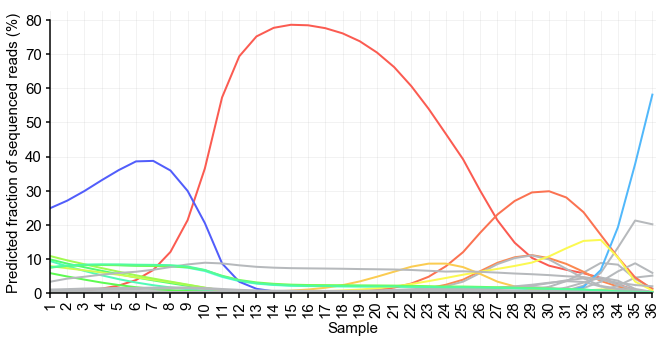

In [8]:
plot_inferred_trajectories(
    modelexp = f'modelexp_{datagroup}_rs', 
    dataset_nm = f'{datagroup}--pace_num-{pnum}--threshold-5--read_len-1--min_gt_frequency-0.0--proposal_type-smart',
    out_fn = results_dir + f'p{pnum}_t5_rl1.pdf', 
    title = '',
)

Saving to /ahg/regevdata/projects/CRISPR-libraries/prj2/evolution/abe8e/results/fig_plot_full_trajectories/p3_t5_rl100.pdf ...


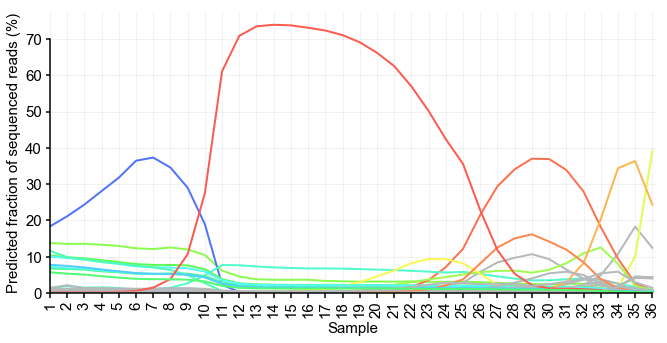

In [22]:
plot_inferred_trajectories(
    modelexp = f'modelexp_{datagroup}_rs', 
    dataset_nm = f'{datagroup}--pace_num-{pnum}--threshold-5--read_len-100--min_gt_frequency-0.0--proposal_type-smart',
    out_fn = results_dir + f'p{pnum}_t5_rl100.pdf', 
    title = '',
)

## reduced readlen

Loading true df ...
Saving to /ahg/regevdata/projects/CRISPR-libraries/prj2/evolution/abe8e/results/fig_plot_full_trajectories/p2_t5_rl1.pdf ...


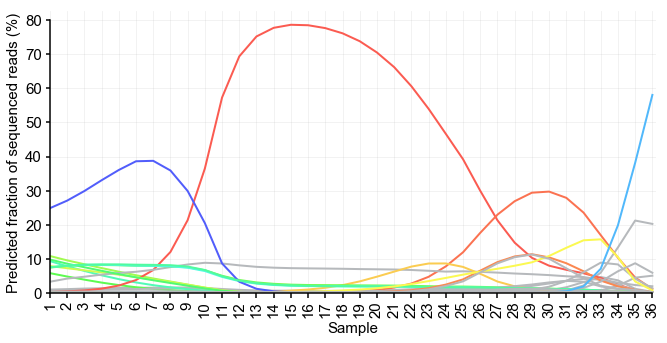

In [7]:
plot_inferred_trajectories(
    modelexp = f'modelexp_simple_rl_rs', 
    dataset_nm = f'simple_rl--pace_num-2--threshold-5--read_len-1--min_gt_frequency-0--proposal_type-smart',
    out_fn = results_dir + f'p2_t5_rl1.pdf', 
    title = '',
)

## added noise

Saving to /ahg/regevdata/projects/CRISPR-libraries/prj2/evolution/abe8e/results/fig_plot_full_trajectories/varynoise_p2_t5_rl1_noise0.03.pdf ...


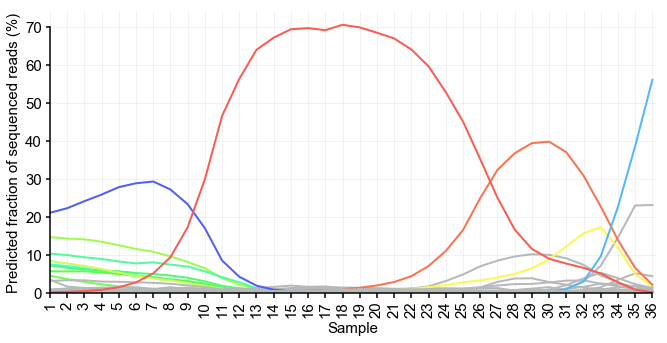

In [9]:
plot_inferred_trajectories(
    modelexp = f'modelexp_varynoisev2_p2_rs', 
    dataset_nm = f'varynoisev2_p2--pace_num-2--threshold-5--min_gt_frequency-0--read_len-1--noise-0.03--proposal_type-smart--noiserep-0',
    out_fn = results_dir + f'varynoise_p2_t5_rl1_noise0.03.pdf', 
    title = '',
)

Saving to /ahg/regevdata/projects/CRISPR-libraries/prj2/evolution/abe8e/results/fig_plot_full_trajectories/varynoise_p2_t5_rl1_noise0.05.pdf ...


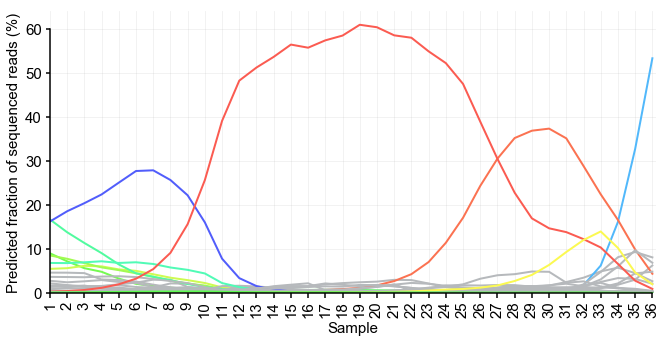

In [11]:
plot_inferred_trajectories(
    modelexp = f'modelexp_varynoisev2_p2_rs', 
    dataset_nm = f'varynoisev2_p2--pace_num-2--threshold-5--min_gt_frequency-0--read_len-1--noise-0.05--proposal_type-smart--noiserep-1',
    out_fn = results_dir + f'varynoise_p2_t5_rl1_noise0.05.pdf', 
    title = '',
)